In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from chimeric_tools.Data import covid_data
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import norm
class skforcast:
    def __init__(self, model = None, load = False, path = None, location = None ,target = None, time_freq = 'W',step = 0.1,quantial = None):
        if target == "cases":
        
            self.quantial = [0.025,0.100,0.250,0.500,0.750,0.900,0.975]
        else:
            self.quantial = [0.010,0.025,0.050,0.100,0.150,0.200,0.250,0.300,0.350,0.400,0.450,0.500,0.550,0.600,0.650,0.700,0.750,0.800,0.850,0.900,0.950,0.975,0.990]
        if load:
            self.model = self.load_model(path)
        self.location = location
        self.data = covid_data(geo_values=[location])
        self.data = self.format_data(self.data,time_freq)
        self.train_data, self.val_data = self.divide_data(self.data,step)
        # print(len(self.train_data),len(self.val_data),len(self.data))
        self.train_label = self.train_data[target]
        self.val_label = self.val_data[target]
        self.target = target
        self.time_freq = time_freq
        self.model = self.train_model(self.train_data)

    def load_model(self, path):
        import pickle
        import joblib
        if path is None:
            raise ValueError("Path is not defined")
        else:
            return joblib.load(path)
    def format_data(self, data,time_freq):
        data['time_value'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

        data = data.set_index("time_value")
        data = data.asfreq(time_freq)
        data = data.sort_index()
        return data
    def divide_data(self, data,step):
        train_data = data.iloc[:1-int(len(data)*step)]
        val_data = data.iloc[1-int(len(data)*step):]
        return train_data, val_data
    def train_model(self, train_data):
        #  Create and fit forecaster
        # ==============================================================================
        forecaster = ForecasterAutoreg(
                    # regressor = RandomForestRegressor(random_state=0),
                    regressor = Ridge(),
                    lags      = 15
                )
        forecaster.fit(y=train_data[self.target])
        # Lags used as predictors
        # lags_grid = [10, 20]

        # # Regressor's hyperparameters
        # param_grid = {'n_estimators': [100, 500],
        #             'max_depth': [3, 5, 10]}

        # results_grid = grid_search_forecaster(
        #                         forecaster         = forecaster,
        #                         y                  = self.data['cases'],
        #                         param_grid         = param_grid,
        #                         lags_grid          = lags_grid,
        #                         steps              = len(train_data),
        #                         refit              = True,
        #                         metric             = 'mean_squared_error',
        #                         initial_train_size = int(len(train_data)*0.5),
        #                         fixed_train_size   = False,
        #                         return_best        = True,
        #                         verbose            = False
        #             )
        return forecaster
    def validate(self, val_data):
        #  Predict on validation data
        # ==============================================================================
        y_pred = self.model.predict(steps = len(val_data))
        #  Compute error
        # ==============================================================================]
        error = mean_squared_error(y_pred, val_data[self.target])
        return error
    def cal_sigma(self):
        y_pred = self.model.predict(steps = len(self.val_data))
        pair = np.array(list(zip(y_pred, self.val_data[self.target])))
        sigma = np.std(pair)
        return sigma

    def predict(self, week_ahead):
        #  Predict on validation data
        # ==============================================================================
        y_pred = self.model.predict(steps = len(self.val_data)+week_ahead)
        return y_pred[-week_ahead:]
    def plot_val(self):
        #  Plot validation data
        # ==============================================================================
        plt.figure(figsize=(12, 8))
        y_pred = self.model.predict(steps = len(self.val_data))
        plt.plot(self.val_data[self.target], label='Actual')
        plt.plot(y_pred, label='Predicted')
        plt.legend()
        plt.show()
    def output_quantial(self,week_ahead):
        miu_list = self.predict(week_ahead).values
        sigma = self.cal_sigma()
        ppf = []
        forecaster_date = self.val_data['date'].iloc[-1]
        location = self.location
        for i in range(week_ahead):
            ppf.append(norm.ppf(self.quantial,miu_list[i],sigma))
        output = pd.DataFrame(columns=['forecast_date','target','target_end_date','location','type','quantile','value'])
        for idx,ppf in enumerate(ppf):
            quantial = self.quantial
            for q,p in zip(quantial,ppf):
                forecaster_date = forecaster_date
                location = location
                # tranform the upper charter to lower case
                if self.time_freq == 'W':
                    target = str(idx+1) +" wk ahead inc case"
                else:
                    target = str(idx+1) +" day ahead inc case"
                target_end_date = self.val_data['date'].iloc[-1]+pd.Timedelta(weeks=idx+1)
                type = "point"
                quantial = q
                value = p
                #add the row to the dataframe
                output.loc[len(output)] = [forecaster_date,target,target_end_date,location,type,quantial,value] 
                
                # output = output.append({'forecast_date':forecaster_date,'target':target,'target_end_date':target_end_date,'location':location,'type':type,'quantile':quantial,'value':value},ignore_index=True)
        output.to_csv(str(forecaster_date)+"-"+self.target+".csv",index=False)
    
    
model = skforcast(location = "42",target = 'cases')
model_death = skforcast(location = "42",target = 'deaths')
model_hosps = skforcast(location = "42",target = 'hosps',time_freq='D')

/Users/vincent/Desktop/RA/chimeric-tools/src/chimeric_tools/Data.py:95: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(stream, compression="gzip")
/Users/vincent/Desktop/RA/chimeric-tools/src/chimeric_tools/Data.py:113: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(stream, compression="gzip")
/Users/vincent/Desktop/RA/chimeric-tools/src/chimeric_tools/Data.py:131: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(stream, compression="gzip")
/Users/vincent/Desktop/RA/chimeric-tools/src/chimeric_tools/Data.py:95: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(stream, compression="gzip")
/Users/vincent/Desktop/RA/chimeric-tools/src/chimeric_tools/Data.py:113: DtypeWarning: Columns (0) have mixed type

Exception: `y` has missing values.

In [70]:
model.output_quantial(week_ahead = 8)
model_death.output_quantial(week_ahead = 20)
model_hosps.output_quantial(week_ahead = 20)

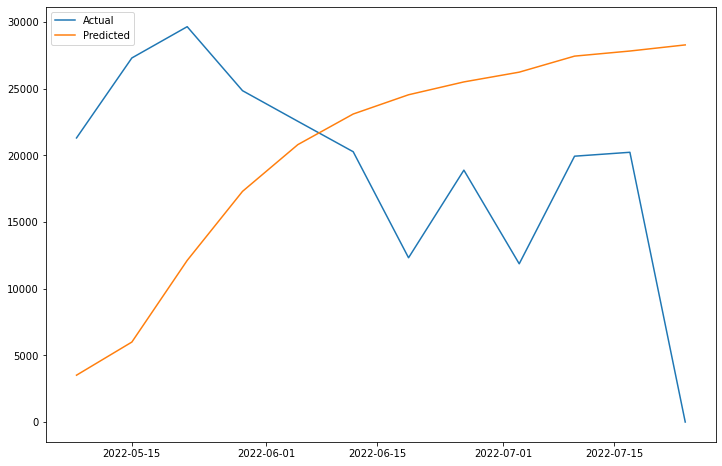

In [29]:
model.plot_val()

In [25]:
model.validate(model.val_data)
model.predict(week_ahead = 8)

2022-07-31    8151.48
2022-08-07    8137.52
2022-08-14    8149.24
2022-08-21    8149.24
2022-08-28    8149.24
2022-09-04    8149.24
2022-09-11    8149.24
2022-09-18    8149.24
Freq: W-SUN, Name: pred, dtype: float64